### Pro Nutzer gruppierte Pixel ..... ich möchte gern Pixel paarweise vergleichen damit ich gucken kann ob die kollidieren oder nicht

In [1]:
from src.data.dataset_functions import get_dataframe

dataFrame = get_dataframe(True) # sample data only
from src.features.feature_functions import group_dataframe_by_user
groupedFrame = group_dataframe_by_user(dataFrame)

providing ../data/raw/2022_place_canvas_history-000000000050.csv ...
../data/raw/2022_place_canvas_history-000000000050.csv is already in data/raw
:: loading settings :: url = jar:file:/usr/local/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/vscode/.ivy2/cache
The jars for the packages stored in: /home/vscode/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8a237321-5c04-486f-ac36-65b357cba404;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
downloading https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar ...
	[SUCCESSFUL ] graphframes#graphframes;0.8.2-spark3.2-s_2.12!graphframes.jar (71ms)
downloading https://repo1.maven.org/maven2/org/slf4j/slf4j-api/1.7.16/slf4j-api-1.7.16.jar ...
	[SUCCESSFUL ] org.slf4j#slf4j-api;1.7.16!slf4j-api.jar (58ms)
:: resolution report :: resolve 4314ms :: artifacts dl 138ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	----------

In [3]:
groupedFrame.show(1)

+--------------------+-----+--------------------+--------------------+--------------------+-------------------------+
|             user_id|count|     collect_list(x)|     collect_list(y)|     collect_list(t)|collect_list(pixel_color)|
+--------------------+-----+--------------------+--------------------+--------------------+-------------------------+
|AxBTmhBMbr1sbDw/2...|   20|[1447, 1617, 655,...|[5, 16, 1896, 191...|[184, 1417, 1726,...|     [#FFA800, #FF4500...|
+--------------------+-----+--------------------+--------------------+--------------------+-------------------------+
only showing top 1 row



### Hmmm leider bringen mir die aggregierten Pixel gerade nichts. Ich brauche einzelne Pixel

In [4]:
dataFrame.show(1)

+--------------------+---+----+---+-----------+
|             user_id|  x|   y|  t|pixel_color|
+--------------------+---+----+---+-----------+
|vKtmwRQwAYtw5poO4...|804|1992|  0|    #FF3881|
+--------------------+---+----+---+-----------+
only showing top 1 row



### Ich möchte jeden Pixel mit allen anderen Pixeln vergleichen.. Self Join also! 
Weil ich jedes Pixelpaar nur einmal brauche muss ich Pixel1 - Pixel2 und Pixel2 - Pixel1 wie Duplikate entfernen

...

Idee: ich nutze die Ordnung in der Zeit! Damit gibt es eine feste Reihenfolge von Pixeln in der verglichen wird und Pixel2-Pixel1 kommt nie vor

-> df2.t > df1.t

In [2]:
import pyspark.sql.functions as F
from src.models.models import RZModel

print("Box xy max "+str(RZModel.max_xy_dist))
print("Box t max " +str(RZModel.max_t_dist))

Box xy max 80
Box t max 1200


In [3]:
RZModel.max_xy_dist = 80 # zum rumspielen

In [4]:
selfjoinedFrame = dataFrame.alias('df1').join(dataFrame.alias('df2'),F.col('df1.user_id') == F.col('df2.user_id'),'inner')
selfjoinedFrame = selfjoinedFrame.where('df2.t > df1.t').where('df2.t <= df1.t + 2*'+str(RZModel.max_t_dist))
selfjoinedFrame = selfjoinedFrame.where('Abs(df2.x - df1.x) <= 2*'+str(RZModel.max_xy_dist))
selfjoinedFrame = selfjoinedFrame.where('Abs(df2.y - df1.y) <= 2*'+str(RZModel.max_xy_dist))
selfjoinedFrame = selfjoinedFrame.select(F.col('df1.user_id'),F.col('df1.x').alias("x1"),F.col('df2.x').alias('x2'),F.col('df1.y').alias("y1"),F.col('df2.y').alias('y2'),F.col('df1.t').alias("t1"),F.col('df2.t').alias('t2'),F.col('df1.pixel_color').alias("c1"),F.col('df2.pixel_color').alias('c2'))

In [5]:
selfjoinedFrame.show(5)

+--------------------+---+---+----+----+----+----+-------+-------+
|             user_id| x1| x2|  y1|  y2|  t1|  t2|     c1|     c2|
+--------------------+---+---+----+----+----+----+-------+-------+
|++3l0k1HSXKiAsHkH...|684|668|1270|1211|1058|1381|#D4D7D9|#D4D7D9|
|++3l0k1HSXKiAsHkH...|684|664|1270|1240|1058|1721|#D4D7D9|#9C6926|
|++3l0k1HSXKiAsHkH...|684|667|1270|1240|1058|2057|#D4D7D9|#9C6926|
|++3l0k1HSXKiAsHkH...|684|663|1270|1240|1058|2399|#D4D7D9|#9C6926|
|++3l0k1HSXKiAsHkH...|684|653|1270|1229|1058|2779|#D4D7D9|#FFFFFF|
+--------------------+---+---+----+----+----+----+-------+-------+
only showing top 5 rows



Das sieht schonmal gut aus :) jetzt aggregieren...

In [5]:
import src.features.feature_functions
pixelPaareProNutzer = group_dataframe_by_user(selfjoinedFrame)


In [7]:
pixelPaareProNutzer.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|             user_id|count|    collect_list(x1)|    collect_list(x2)|    collect_list(y1)|    collect_list(y2)|    collect_list(t1)|    collect_list(t2)|    collect_list(c1)|    collect_list(c2)|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|FjHp8Fg+uuheibUWk...|   88|[998, 998, 998, 9...|[998, 998, 998, 9...|[1466, 1466, 1466...|[1466, 1466, 1466...|[60, 60, 60, 60, ...|[420, 420, 780, 1...|[#000000, #000000...|[#000000, #000000...|
|VcHUE/HttS4Zm0734...|   79|[1537, 1537, 1537...|[1537, 1537, 1537...|[1844, 1844, 1844...|[1844, 1844, 1844...|[103, 103, 103, 1...|[463, 823, 823, 1...|[#000000, #000000...|[#000000, #000000...|
|zr4zPH9hAud2gg

Das ist jetzt eine Liste von paarweise verbundenen Pixeln pro Nutzer...

Die Liste ist ja wer die meisten Pixelpaare hat. Als Bild wäre es schön von einem Nutzer die Paare zu zeichnen den wir schon haben... Das Beispiel war "AxBTmhBMbr1sbDw/2liFySQ4h6lH1bZSyjS9RtcBxvMyafVj+e2grv9teqbU9JkFDCPlgIfWH+L2CzKeSBdB4w=="

gucken wir mal ob wir diese Pixelpaare für einen Nutzer zeichnen können

In [6]:
user_pixel_paare = pixelPaareProNutzer.where(F.col('user_id') == 'AxBTmhBMbr1sbDw/2liFySQ4h6lH1bZSyjS9RtcBxvMyafVj+e2grv9teqbU9JkFDCPlgIfWH+L2CzKeSBdB4w==').head(1)[0]

In [11]:
print(user_pixel_paare)

Row(user_id='AxBTmhBMbr1sbDw/2liFySQ4h6lH1bZSyjS9RtcBxvMyafVj+e2grv9teqbU9JkFDCPlgIfWH+L2CzKeSBdB4w==', count=30, collect_list(x1)=[1447, 1447, 1447, 1447, 1636, 1636, 1636, 1287, 1287, 1287, 1310, 1310, 1617, 1617, 1617, 1617, 655, 655, 612, 612, 1575, 658, 658, 658, 1403, 777, 1741, 1741, 586, 1611], collect_list(x2)=[1287, 1310, 1575, 1403, 1617, 1575, 1741, 1310, 1403, 1299, 1403, 1299, 1575, 1741, 1611, 1765, 586, 656, 586, 656, 1611, 777, 788, 584, 1299, 788, 1611, 1765, 656, 1765], collect_list(y1)=[5, 5, 5, 5, 21, 21, 21, 8, 8, 8, 10, 10, 16, 16, 16, 16, 1896, 1896, 1917, 1917, 7, 14, 14, 14, 2, 8, 10, 10, 1931, 33], collect_list(y2)=[8, 10, 7, 2, 16, 7, 10, 10, 2, 20, 2, 20, 7, 10, 33, 8, 1931, 1884, 1931, 1884, 33, 8, 11, 26, 20, 11, 33, 8, 1884, 8], collect_list(t1)=[184, 184, 184, 184, 492, 492, 492, 801, 801, 801, 1109, 1109, 1417, 1417, 1417, 1417, 1726, 1726, 1726, 1726, 1726, 2035, 2035, 2035, 2344, 2344, 2344, 2344, 2653, 3269], collect_list(t2)=[801, 1109, 1726, 2344,

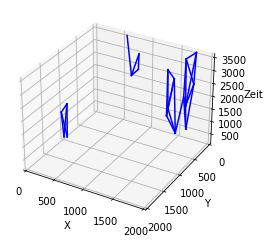

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from src.visualization.visuialization_functions import new_xyt_plot,plot_line

subplot = new_xyt_plot()
for i in np.arange(0,len(user_pixel_paare['collect_list(x1)'])):
    subplot = plot_line([user_pixel_paare['collect_list(x1)'][i],user_pixel_paare['collect_list(x2)'][i]],[user_pixel_paare['collect_list(y1)'][i],user_pixel_paare['collect_list(y2)'][i]],[user_pixel_paare['collect_list(t1)'][i],user_pixel_paare['collect_list(t2)'][i]],color='blue',subplot=subplot,finish=False)

plt.show()

nice! vlt noch die Pixel des Nutzers dazu malen

In [13]:
groupedFrame.show(1)

+--------------------+-----+--------------------+--------------------+--------------------+-------------------------+
|             user_id|count|     collect_list(x)|     collect_list(y)|     collect_list(t)|collect_list(pixel_color)|
+--------------------+-----+--------------------+--------------------+--------------------+-------------------------+
|AxBTmhBMbr1sbDw/2...|   20|[1447, 1617, 655,...|[5, 16, 1896, 191...|[184, 1417, 1726,...|     [#FFA800, #FF4500...|
+--------------------+-----+--------------------+--------------------+--------------------+-------------------------+
only showing top 1 row



In [8]:
row = groupedFrame.head(1)[0]
user_id , count ,xs , ys , ts , pixel_color = list(row)

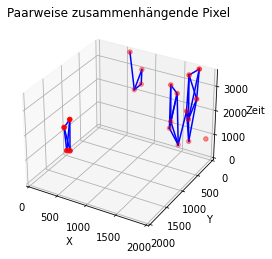

In [9]:
from src.visualization.visuialization_functions import new_xyt_plot,plot_pixellist
subplot = new_xyt_plot()

subplot = plot_pixellist([xs,ys,ts],color='red',subplot=subplot,finish=False)
for i in np.arange(0,len(user_pixel_paare['collect_list(x1)'])):
    subplot = plot_line([user_pixel_paare['collect_list(x1)'][i],user_pixel_paare['collect_list(x2)'][i]],[user_pixel_paare['collect_list(y1)'][i],user_pixel_paare['collect_list(y2)'][i]],[user_pixel_paare['collect_list(t1)'][i],user_pixel_paare['collect_list(t2)'][i]],color='blue',subplot=subplot,finish=False)

subplot.set_title('Paarweise zusammenhängende Pixel')
subplot.set_ylim([2001,0])
subplot.set_xlim([0,2001])
subplot.set_zlim([0,3601])

plt.savefig('pixelpaare.png',dpi=300)
plt.show()


### mit so einem Graphen gibts einen Algorithmus für Zusammenhangskomponenten...

Der Algorithmus vom GraphFrame package braucht eine ID für vertices. monotonically_increasing_id() vergibt eindeutige IDs. Nur sind die nicht zusammenhängend wegen den verteilten Daten auf denen gerechnet wird! Naja brauchen wir auch nicht

In [23]:
dataFrame.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- x: integer (nullable = true)
 |-- y: integer (nullable = true)
 |-- t: long (nullable = true)
 |-- pixel_color: string (nullable = true)



In [10]:
withIDFrame = dataFrame.withColumn('pixel_id',F.monotonically_increasing_id())

erstmal wieder nur für den speziellen Nutzer weiter untersuchen

In [11]:
user_pixel_Frame = withIDFrame.where(F.col('user_id') == 'AxBTmhBMbr1sbDw/2liFySQ4h6lH1bZSyjS9RtcBxvMyafVj+e2grv9teqbU9JkFDCPlgIfWH+L2CzKeSBdB4w==')

In [34]:
user_pixel_Frame.show(5)

+--------------------+----+---+----+-----------+-----------+
|             user_id|   x|  y|   t|pixel_color|   pixel_id|
+--------------------+----+---+----+-----------+-----------+
|AxBTmhBMbr1sbDw/2...|1447|  5| 184|    #FFA800|     102567|
|AxBTmhBMbr1sbDw/2...|1636| 21| 492|    #FFFFFF| 8589974236|
|AxBTmhBMbr1sbDw/2...|1287|  8| 801|    #3690EA| 8590139860|
|AxBTmhBMbr1sbDw/2...|1926| 19| 801|    #BE0039| 8590139861|
|AxBTmhBMbr1sbDw/2...|1310| 10|1109|    #2450A4|17180008216|
+--------------------+----+---+----+-----------+-----------+
only showing top 5 rows



jetzt brauchen wir eine Liste von Edges für den Graphen. Kennen wir schon wie man das macht: Self Join unter der Bedingung dass die Pixel kollidieren.
Als Ergebnis interessieren uns nur die IDs der Pixel.

In [12]:
# user_pixe_Frame ist zwar schon auf einen user reduziert was die erste Bedingung sinnlos macht
# aber ich lasse es mal drin falls es copy pasted wird für die allgemeine Variante später
edgeFrame = user_pixel_Frame.alias('df1').join(user_pixel_Frame.alias('df2'),F.col('df1.user_id') == F.col('df2.user_id'),'inner')
edgeFrame = edgeFrame.where('df2.t > df1.t').where('df2.t <= df1.t + 2*'+str(RZModel.max_t_dist))
edgeFrame = edgeFrame.where('Abs(df2.x - df1.x) <= 2*'+str(RZModel.max_xy_dist))
edgeFrame = edgeFrame.where('Abs(df2.y - df1.y) <= 2*'+str(RZModel.max_xy_dist))
edgeFrame = edgeFrame.select(F.col('df1.pixel_id').alias('src'),F.col('df2.pixel_id').alias("dst"))

In [36]:
edgeFrame.show(5)

+----------+-----------+
|       src|        dst|
+----------+-----------+
|    102567| 8590139860|
|    102567|17180008216|
|    102567|25770023874|
|    102567|42949737466|
|8589974236|25769866243|
+----------+-----------+
only showing top 5 rows



In [13]:
# der kann das nur wenn die Spalten genau so heissen... id bei den vertices und src,dst bei edges
vertexFrame = user_pixel_Frame.withColumnRenamed('pixel_id','id')

In [14]:
from graphframes import *
# na dann los gehts

g = GraphFrame(vertexFrame,edgeFrame)

In [18]:
print(g)
display(g.vertices)
display(g.edges)

GraphFrame(v:[id: bigint, user_id: string ... 4 more fields], e:[src: bigint, dst: bigint])


DataFrame[user_id: string, x: int, y: int, t: bigint, pixel_color: string, id: bigint]

DataFrame[src: bigint, dst: bigint]

In [15]:
result = g.connectedComponents()

In [20]:
result.show(5)

+--------------------+----+---+----+-----------+-----------+----------+
|             user_id|   x|  y|   t|pixel_color|         id| component|
+--------------------+----+---+----+-----------+-----------+----------+
|AxBTmhBMbr1sbDw/2...|1447|  5| 184|    #FFA800|     102567|    102567|
|AxBTmhBMbr1sbDw/2...|1636| 21| 492|    #FFFFFF| 8589974236|    102567|
|AxBTmhBMbr1sbDw/2...|1287|  8| 801|    #3690EA| 8590139860|    102567|
|AxBTmhBMbr1sbDw/2...|1926| 19| 801|    #BE0039| 8590139861|8590139861|
|AxBTmhBMbr1sbDw/2...|1310| 10|1109|    #2450A4|17180008216|    102567|
+--------------------+----+---+----+-----------+-----------+----------+
only showing top 5 rows



Nach Zusammenhangskomponenten gruppieren...

In [16]:
from src.features.feature_functions import group_dataframe_by_columns
component_pixellist_frame = group_dataframe_by_columns(result,['user_id','component'])

In [22]:
component_pixellist_frame.show(5)

+--------------------+-----------+-----+--------------------+--------------------+--------------------+-------------------------+--------------------+
|             user_id|  component|count|     collect_list(x)|     collect_list(y)|     collect_list(t)|collect_list(pixel_color)|    collect_list(id)|
+--------------------+-----------+-----+--------------------+--------------------+--------------------+-------------------------+--------------------+
|AxBTmhBMbr1sbDw/2...|     102567|   11|[1447, 1636, 1287...|[5, 21, 8, 10, 16...|[184, 492, 801, 1...|     [#FFA800, #FFFFFF...|[102567, 85899742...|
|AxBTmhBMbr1sbDw/2...|25770023870|    4|[655, 612, 586, 656]|[1896, 1917, 1931...|[1726, 1726, 2653...|     [#B44AC0, #E4ABFF...|[25770023870, 257...|
|AxBTmhBMbr1sbDw/2...|34359879882|    4|[658, 777, 788, 584]|     [14, 8, 11, 26]|[2035, 2344, 2961...|     [#FF4500, #FFA800...|[34359879882, 429...|
|AxBTmhBMbr1sbDw/2...| 8590139861|    1|              [1926]|                [19]|            

In [17]:
datarows = component_pixellist_frame.collect()
pixellistlist = []

for row in datarows:
    xs = row['collect_list(x)']
    ys = row['collect_list(y)']
    ts = row['collect_list(t)']
    pixellistlist.append([xs,ys,ts])

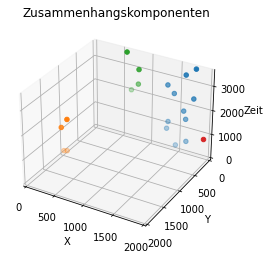

In [18]:
from src.visualization.visuialization_functions import plot_list_of_pixellist

subplot = new_xyt_plot()
subplot = plot_list_of_pixellist(pixellistlist,subplot=subplot,finish=False)

subplot.set_title('Zusammenhangskomponenten')
subplot.set_ylim([2001,0])
subplot.set_xlim([0,2001])
subplot.set_zlim([0,3601])

plt.savefig('pixelklassen.png',dpi=300)
plt.show()


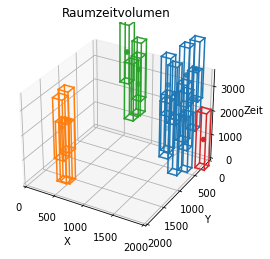

In [19]:
from src.visualization.visuialization_functions import plot_pixel_boundingbox
subplot = new_xyt_plot()
#subplot = plot_list_of_pixellist(pixellistlist,subplot=subplot,finish=False)

colorpicker = iter(plt.cm.tab10(
    np.linspace(0, 1, 10)))
for pixellist in pixellistlist:
    color = next(colorpicker)
    pixellistcolor = [color]
    subplot=plot_pixellist(pixellist, color=pixellistcolor, subplot=subplot, finish=False)
    x_list, y_list, t_list = list(pixellist)
    for i in np.arange(0,len(x_list)):
        plot_pixel_boundingbox(x_list[i],y_list[i],t_list[i],color,subplot,finish=False)

subplot.set_title('Raumzeitvolumen')
subplot.set_ylim([2001,0])
subplot.set_xlim([0,2001])
subplot.set_zlim([0,3601])

plt.savefig('raumzeiten.png',dpi=300)
plt.show()